In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from scipy.optimize import minimize
import cvxpy as cp
from sklearn.metrics import mean_squared_error

In [64]:
class LassoReg:
    def __init__(self, step_size, max_iterations, l1_penalty, tolerance):
        self.step_size = step_size
        self.max_iterations = max_iterations
        self.l1_penalty = l1_penalty
        self.tolerance = tolerance
        self.m = None
        self.n = None
        self.W = None
        self.X = None
        self.Y = None
        self.J = []  # Initialize J as an empty list
        self.iterations = None

    def fit(self, X, Y, algo, agents=None):
        self.m, self.n = X.shape
        self.W = np.zeros(self.n)
        self.X = X
        self.Y = Y

        if algo == "gd":
            self.gradient_descent()
        elif algo == "admm":
            self.admm_fit()
        elif algo == "distributed_admm":
            self.distributed_admm(agents)
        else:
            raise ValueError("Invalid algorithm")


    def gradient_descent(self):
            for i in range(1, self.max_iterations + 1):
                Y_predict = self.predict(self.X).flatten()

                soft_term = self.soft_threshold(self.W, self.l1_penalty)
                dW = (-2 * self.X.T @ (self.Y - Y_predict) + soft_term) / self.m
                new_W = self.W - self.step_size * dW

                if np.mean(np.abs(new_W - self.W)) < self.tolerance:
                    break

                self.J.append((np.mean(np.abs(new_W - self.W)),))
                self.W = new_W
                self.iterations = i


    def admm_fit(self):
        rho = self.step_size
        z = np.zeros(self.n)
        u = np.zeros(self.n)
        I = np.eye(self.n)

        abs_tol = self.tolerance
        rel_tol = abs_tol * 100

        for i in range(1, self.max_iterations + 1):
            last_z = z

            self.W = np.linalg.solve(self.X.T @ self.X + rho * I, self.X.T @ self.Y + rho * (z - u))
            z = self.soft_threshold(self.W + u, self.l1_penalty / rho)
            u = u + self.W - z

            r_norm = np.linalg.norm(self.W - z)  # primary residual
            s_norm = np.linalg.norm(-rho * (z - last_z))  # dual residual
            tol_prim = np.sqrt(self.n) * abs_tol + rel_tol * max(np.linalg.norm(self.W), np.linalg.norm(-z))
            tol_dual = np.sqrt(self.n) * abs_tol + rel_tol * np.linalg.norm(rho * u)

            self.iterations = i
            self.J.append(np.array([r_norm, s_norm, tol_prim, tol_dual]))

            if r_norm < tol_prim and s_norm < tol_dual:
                break

        self.W = self.W.reshape(1, -1)


    def distributed_admm(self, agents):
        rho = self.step_size
        z = np.zeros(self.n)
        I = np.eye(self.n)

        abs_tol = self.tolerance
        rel_tol = abs_tol * 100
        converged = False

        r, c = self.X.shape
        rows_per_agent = r // agents
        total_rows_used = rows_per_agent * agents

        print("Original X shape:", self.X.shape)
        print("Total rows used:", total_rows_used)

        splitted_X = self.X[:total_rows_used, :].reshape((rows_per_agent, agents, c))
        splitted_Y = np.reshape(self.Y[:total_rows_used], (rows_per_agent, agents))
        self.W = np.zeros((agents, c))
        u = np.zeros((agents, c))

        for i in range(1, self.max_iterations + 1):
            last_z = z
            for j in range(agents):
                self.W[j, :] = np.linalg.solve(splitted_X[:, j, :].T @ splitted_X[:, j, :] + (rho / 2) * I, splitted_X[:, j, :].T @ splitted_Y[:, j] + (rho / 2) * (z - u[j, :]))
            
            # Fusion center aggregates information from agents
            global_W = np.mean(self.W, axis=0)
            global_u = np.mean(u, axis=0)

            # Fusion center updates z based on aggregated information
            z = self.soft_threshold(global_W + global_u, self.l1_penalty / (rho * agents))

            # Distribute updated information to agents
            for j in range(agents):
                u[j, :] = u[j, :] + (self.W[j, :] - z)
                
            global_u = np.mean(u, axis=0)    

            r_norm = np.linalg.norm(global_W - z)  # primary residual
            s_norm = np.linalg.norm(-rho * (z - last_z))  # dual residual
            tol_prim = np.sqrt(self.n) * abs_tol + rel_tol * max(np.linalg.norm(global_W), np.linalg.norm(-z))
            tol_dual = np.sqrt(self.n) * abs_tol + rel_tol * np.linalg.norm(rho * global_u)

            self.iterations = i
            self.J.append((r_norm, s_norm, tol_prim, tol_dual))

            if r_norm < tol_prim and s_norm < tol_dual:
                converged = True
                break

        self.W = global_W.reshape(1, -1)

    def predict(self, X):
        return X @ self.W.T.flatten()

    def loss_function(self, Y, Y_predict, W):
        return 0.5 * np.sum((Y - Y_predict) ** 2) + self.l1_penalty * np.linalg.norm(W, 1)

    def soft_threshold(self, w, th):
        return np.maximum(0, w - th) - np.maximum(0, -w - th)

    def mean_squared_error(self, Y_true, Y_predicted):
        return np.mean((Y_true - Y_predicted) ** 2)  


In [3]:
def plot_predict(label, Y_test, Y_predicted):
    plt.figure()
    plt.title(label)
    plt.scatter(Y_test, Y_predicted)
    plt.plot(Y_test, Y_test, '--')
    plt.xlabel('Actual label')
    plt.ylabel('Predicted label')
    plt.show()

In [4]:
def plot_loss(lasso, label):
    if label == "Loss GD":
        plt.figure()
        plt.title(label)
        plt.plot(lasso.J)
        plt.plot(np.full_like(lasso.J, lasso.tolerance), "--")
        plt.xlabel('Iterations')
        plt.ylabel('Loss')
        plt.show()
    else:
        J_arr = np.array(lasso.J)
        plt.figure()
        plt.subplot(2, 1, 1)
        plt.title(label)
        plt.plot(J_arr[:, 0])
        plt.plot(J_arr[:, 2], "--")
        plt.xlabel('Iterations')
        plt.ylabel('Primary residual')

        plt.subplot(2, 1, 2)
        plt.plot(J_arr[:, 1])
        plt.plot(J_arr[:, 3], "--")
        plt.xlabel('Iterations')
        plt.ylabel('Dual residual')

        plt.show()

In [54]:
def plot_objective(lasso, label):
    plt.figure()
    plt.title(label)
    objective_values = [lasso.loss_function(lasso.Y, lasso.predict(lasso.X), w) for w in lasso.J]
    plt.plot(objective_values)
    plt.xlabel('Iterations')
    plt.ylabel('Objective Function Value')
    plt.show()

In [58]:
def plot_admm_convergence(lasso, label):
    J_arr = np.array(lasso.J)
    plt.figure()
    plt.subplot(2, 1, 1)
    plt.title(label)
    plt.plot(J_arr[:, 0], label='Primary Residual')
    plt.plot(J_arr[:, 2], "--", label='Tolerance')
    plt.xlabel('Iterations')
    plt.ylabel('Primary Residual')
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(J_arr[:, 1], label='Dual Residual')
    plt.plot(J_arr[:, 3], "--", label='Tolerance')
    plt.xlabel('Iterations')
    plt.ylabel('Dual Residual')
    plt.legend()

    plt.show()

In [59]:
def plot_weight_changes(lasso, label):
    J_arr = np.array(lasso.J)
    plt.figure()
    for i in range(lasso.n):
        plt.plot(np.diff(J_arr[:, i]), label=f'Weight {i}')
    plt.title(label)
    plt.xlabel('Iterations')
    plt.ylabel('Change in Weights')
    plt.legend()
    plt.show()

In [5]:
dataset = pd.read_csv('cleaned_data.csv')

In [6]:
dataset.shape

(21613, 26)

In [7]:
X = dataset.drop(columns=['price'])  
Y = dataset['price']

In [26]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

In [27]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [28]:
# add a column of ones to X_train and X_test for the bias term
X_train = np.column_stack([np.ones(X_train.shape[0]), X_train])
X_test = np.column_stack([np.ones(X_test.shape[0]), X_test])

In [83]:
iterations = 200000
step_size = 0.1
l1_penalty = 1
tolerance = 1e-2
agents = 3

## Gradient Descent

In [38]:
start_time = time.time()
print("GD")
lasso = LassoReg(step_size, iterations, l1_penalty, tolerance)
lasso.fit(X_train, Y_train, "gd")
print(lasso.iterations)
Y_predicted = lasso.predict(X_test)
print(np.corrcoef(Y_test, Y_predicted)[0, 1] ** 2)  # R2
end_time = time.time()
print("Time Gradient Descent:", end_time - start_time)

GD
100327
0.6906313288720257
Time Gradient Descent: 243.49083375930786


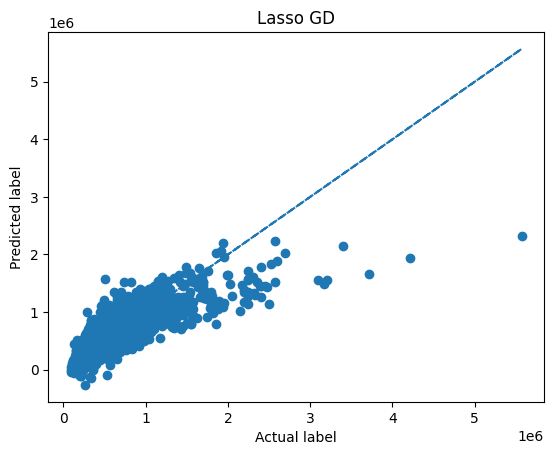

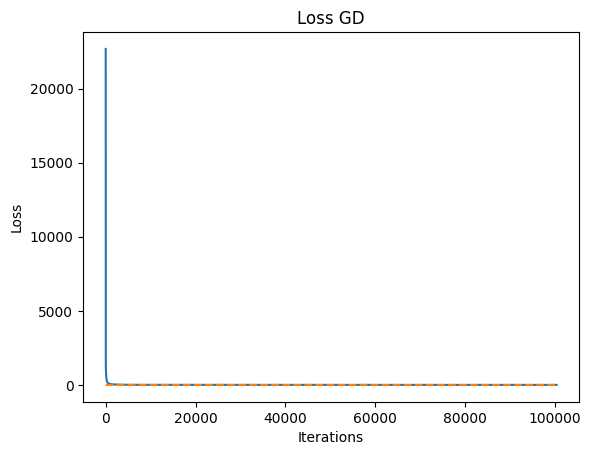

In [41]:
plot_predict("Lasso GD", Y_test, Y_predicted)
plot_loss(lasso, "Loss GD")

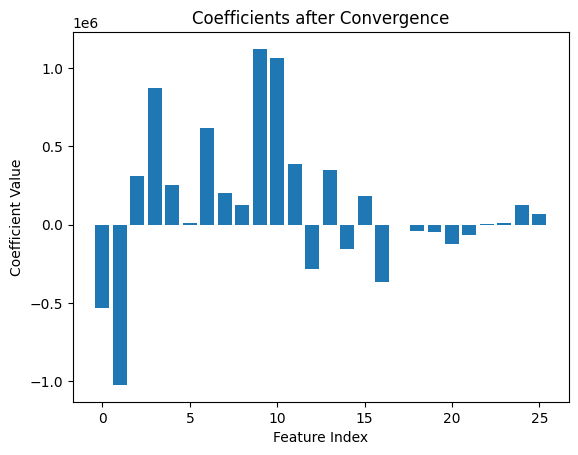

In [51]:
def plot_coefficients(lasso_model):
    plt.figure()
    plt.bar(range(len(lasso_model.W)), lasso_model.W.flatten())
    plt.xlabel('Feature Index')
    plt.ylabel('Coefficient Value')
    plt.title('Coefficients after Convergence')
    plt.show()

# Dopo la convergenza
plot_coefficients(lasso)

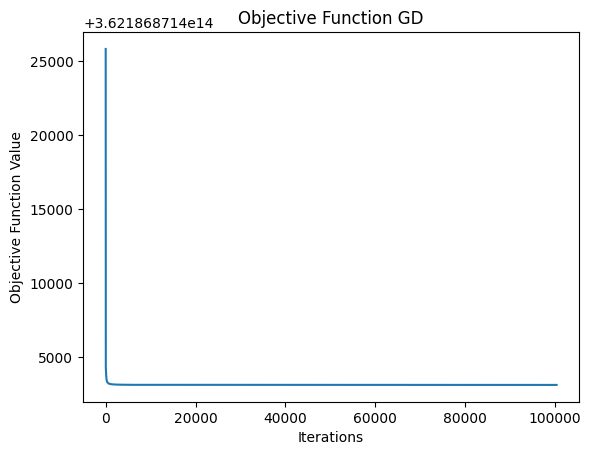

In [55]:
plot_objective(lasso, "Objective Function GD")

In [44]:
#normalize the labels and predicted labels
Y_test_norm = scaler.fit_transform(Y_test.values.reshape(-1, 1)).flatten()
Y_predicted = scaler.fit_transform(Y_predicted.reshape(-1, 1)).flatten()

mean_squared_error(Y_test_norm, Y_predicted)


0.05773019628840685

# ADMM

In [84]:
start_time = time.time()
print("ADMM")
lasso_admm = LassoReg(step_size, iterations, l1_penalty, tolerance)
lasso_admm.fit(X_train, Y_train, "admm")
print(lasso_admm.iterations)
Y_predicted_admm = lasso_admm.predict(X_test)

if Y_test.shape == Y_predicted_admm.shape:
    r2_admm = np.corrcoef(Y_test, Y_predicted_admm)[0, 1] ** 2
    print(r2_admm)
else:
    print("Dimensions of Y_test and Y_predicted_admm do not match.")
end_time = time.time()
print("Time ADMM:", end_time - start_time)

ADMM
3
0.6906807276841809
Time ADMM: 0.010711908340454102


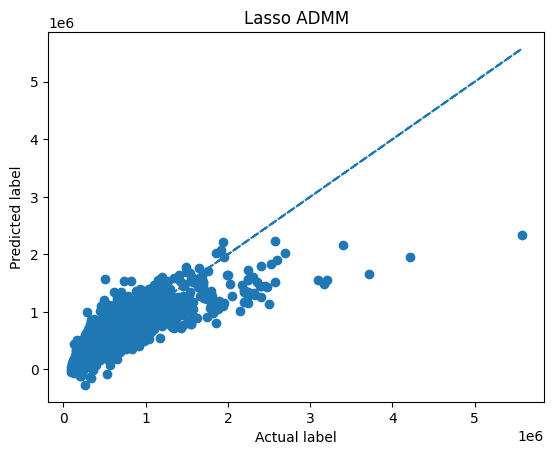

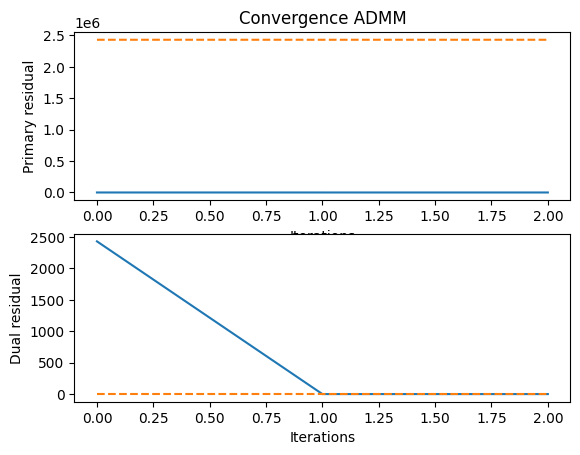

In [85]:
plot_predict("Lasso ADMM", Y_test, Y_predicted_admm)
plot_loss(lasso_admm, "Convergence ADMM")

In [86]:
def plot_admm_loss(lasso, label):
    J_arr = np.array(lasso.J)

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(J_arr[:, 0])
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.title(f'{label} - Loss')

    plt.subplot(1, 2, 2)
    plt.plot(J_arr[:, 1], label='Primary Residual')
    plt.plot(J_arr[:, 2], label='Dual Residual')
    plt.xlabel('Iterations')
    plt.ylabel('Residuals')
    plt.title(f'{label} - Residuals')
    plt.legend()

    plt.show()


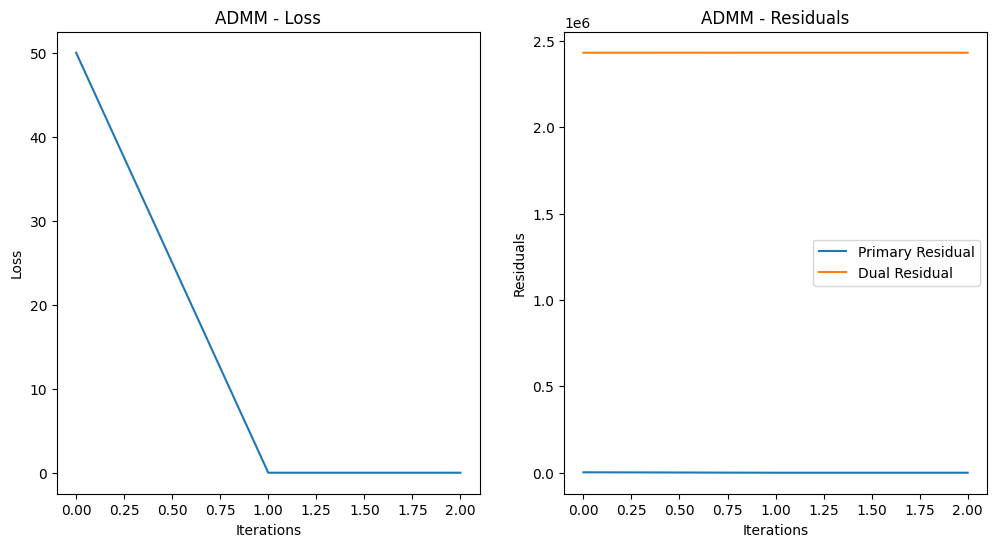

In [87]:
plot_admm_loss(lasso_admm, "ADMM")

In [47]:
Y_predicted_admm = scaler.fit_transform(Y_predicted_admm.reshape(-1, 1)).flatten()

mean_squared_error(Y_test_norm, Y_predicted_admm)

0.05744054670142115

## ADMM splitted by examples

In [48]:
start_time = time.time()
print("Distributed ADMM")
lasso_dist = LassoReg(step_size, iterations, l1_penalty, tolerance)
lasso_dist.fit(X_train, Y_train, "distributed_admm", agents)
print(lasso_dist.iterations)
Y_predicted_dist = lasso_dist.predict(X_test)


if Y_test.shape == Y_predicted_dist.shape:
    r2_dist = np.corrcoef(Y_test, Y_predicted_dist)[0, 1] ** 2
    print(r2_dist)
else:
    print("Dimensions of Y_test and Y_predicted_dist do not match.")
    # Add additional dimension information if needed
    print("Dimension of Y_test:", Y_test.shape)
    print("Dimension of Y_predicted_dist:", Y_predicted_dist.shape)
end_time = time.time()
print("Time Distributed ADMM:", end_time - start_time)

Distributed ADMM
Original X shape: (17290, 26)
Total rows used: 17289
358
0.6907555266580735
Time Distributed ADMM: 8.937918663024902


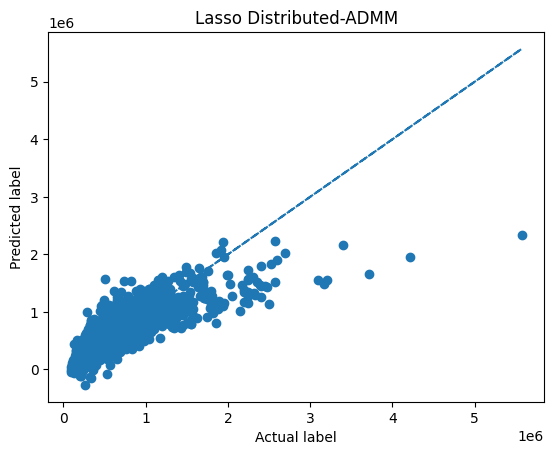

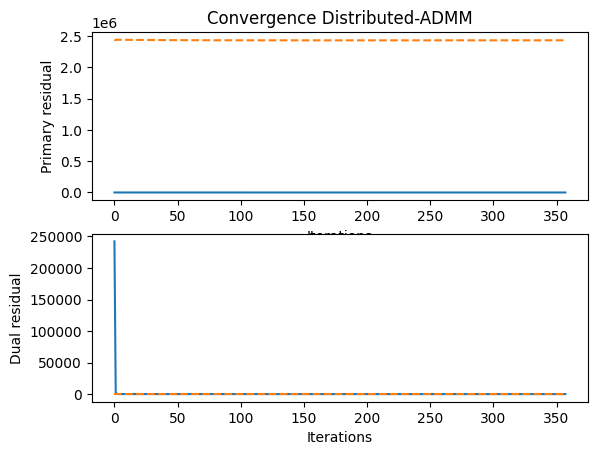

In [49]:
plot_predict("Lasso Distributed-ADMM", Y_test, Y_predicted_dist)
plot_loss(lasso_dist, "Convergence Distributed-ADMM")

In [50]:
Y_predicted_dist = scaler.fit_transform(Y_predicted_dist.reshape(-1, 1)).flatten()

mean_squared_error(Y_test_norm, Y_predicted_dist)

0.05746164207003923

## Dati sintetici


In [88]:
# generation of synthetic data
np.random.seed(42)
n_samples = 10000
n_features = 15

true_coef = np.random.randint(-5, 5, n_features)

X = np.random.randn(n_samples, n_features)

In [89]:
correlation_matrix = np.random.uniform(0.5, 0.5, size=(n_features, n_features))
X = X @ correlation_matrix

In [90]:
noise = np.random.normal(0, 1, n_samples)

In [91]:
Y = X @ true_coef + noise

In [92]:
# split the data into training and testing sets
X_train_syn, X_test_syn, Y_train_syn, Y_test_syn = train_test_split(X, Y, test_size=0.2, random_state=0)

In [93]:
#Lasso parameters
iterations = 200000
step_size = 0.01
l1_penalty = 1
tolerance = 1e-4
agents = 3

In [94]:
#Lasso Regression using Gradient Descent
start_time = time.time()
print("GD")
lasso = LassoReg(step_size, iterations, l1_penalty, tolerance)
lasso.fit(X_train_syn, Y_train_syn, "gd")
print(lasso.iterations)
Y_predicted = lasso.predict(X_test_syn)
print(np.corrcoef(Y_test_syn, Y_predicted)[0, 1] ** 2)  # R2
end_time = time.time()
print("Time Gradient Descent:", end_time - start_time)

GD
4
0.9699403611332114
Time Gradient Descent: 0.0364995002746582


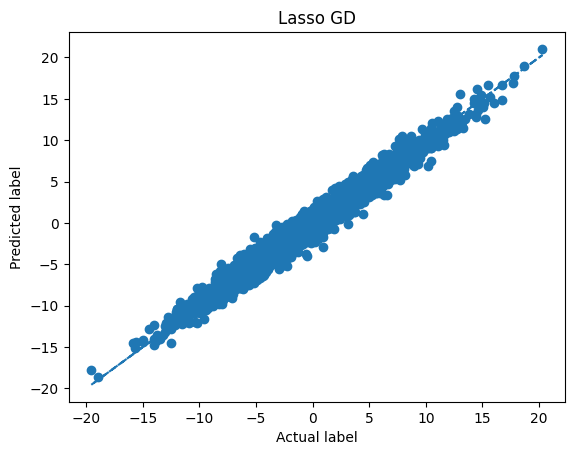

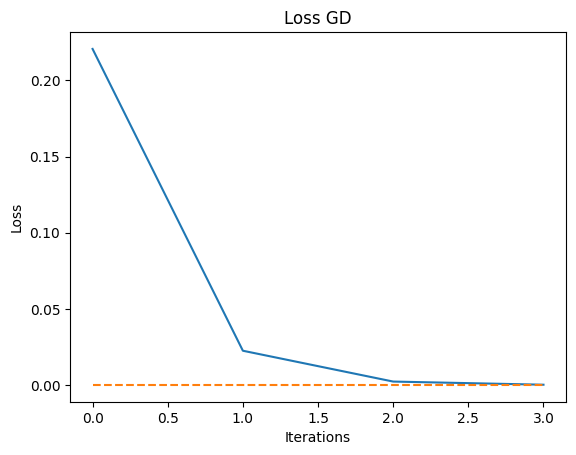

MSE Gradient descent: 1.0153513520955433


In [95]:
plot_predict("Lasso GD", Y_test_syn, Y_predicted)
plot_loss(lasso, "Loss GD")

mean_squared_error(Y_test_syn, Y_predicted)
print("MSE Gradient descent:", mean_squared_error(Y_test_syn, Y_predicted))

In [96]:
#Lasso Regression using ADMM
start_time = time.time()
print("ADMM")
lasso_admm = LassoReg(step_size, iterations, l1_penalty, tolerance)
lasso_admm.fit(X_train_syn, Y_train_syn, "admm")
print(lasso_admm.iterations)
Y_predicted_admm = lasso_admm.predict(X_test_syn)
print(np.corrcoef(Y_test_syn, Y_predicted_admm)[0, 1] ** 2)  # R2
end_time = time.time()
print("Time ADMM:", end_time - start_time)

ADMM
501
0.9699403611332114
Time ADMM: 0.395810604095459


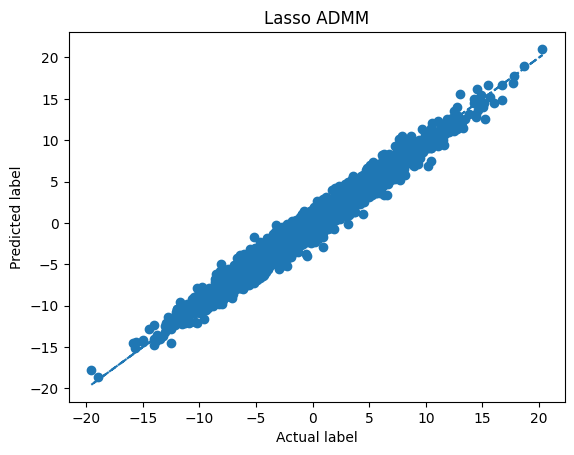

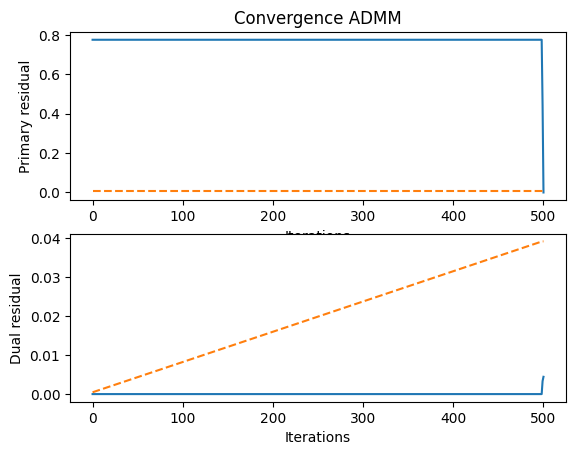

MSE ADMM: 1.0153364760853303


In [97]:
plot_predict("Lasso ADMM", Y_test_syn, Y_predicted_admm)
plot_loss(lasso_admm, "Convergence ADMM")

mean_squared_error(Y_test_syn, Y_predicted_admm)
print("MSE ADMM:", mean_squared_error(Y_test_syn, Y_predicted_admm))

In [98]:
#Lasso Regression using Distributed ADMM
start_time = time.time()
print("Distributed ADMM")
lasso_dist = LassoReg(step_size, iterations, l1_penalty, tolerance)
lasso_dist.fit(X_train_syn, Y_train_syn, "distributed_admm", agents)
print(lasso_dist.iterations)
Y_predicted_dist = lasso_dist.predict(X_test_syn)
print(np.corrcoef(Y_test_syn, Y_predicted_dist)[0, 1] ** 2)  # R2
end_time = time.time()
print("Time Distributed ADMM:", end_time - start_time)

Distributed ADMM
Original X shape: (8000, 15)
Total rows used: 7998
168
0.9699403611332116
Time Distributed ADMM: 0.25438570976257324


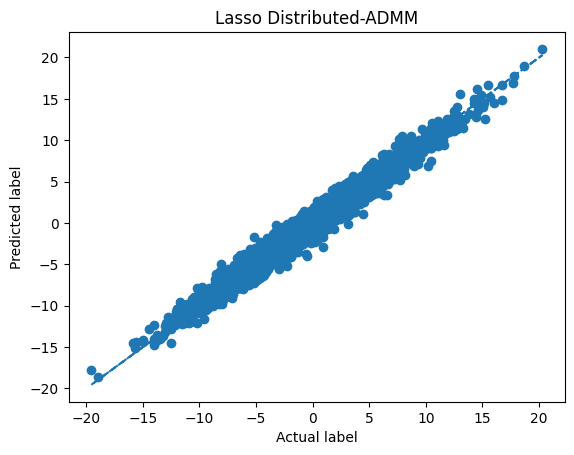

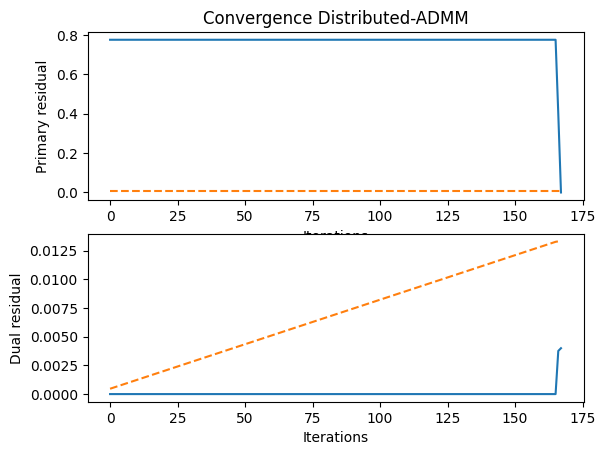

MSE Distributed ADMM: 1.0153286812885933


In [99]:
plot_predict("Lasso Distributed-ADMM", Y_test_syn, Y_predicted_dist)
plot_loss(lasso_dist, "Convergence Distributed-ADMM")

mean_squared_error(Y_test_syn, Y_predicted_dist)
print("MSE Distributed ADMM:", mean_squared_error(Y_test_syn, Y_predicted_dist))

# Altra versione

In [100]:
np.random.seed(42)
n_samples, n_features = 1000, 20

# Genera una matrice casuale di features
X = np.random.randn(n_samples, n_features)

# Genera i coefficienti del modello sparsi
true_coefficients = np.zeros(n_features)
true_coefficients[3] = 3.0
true_coefficients[8] = -2.0

In [101]:
y = X.dot(true_coefficients) + 0.5 * np.random.randn(n_samples)

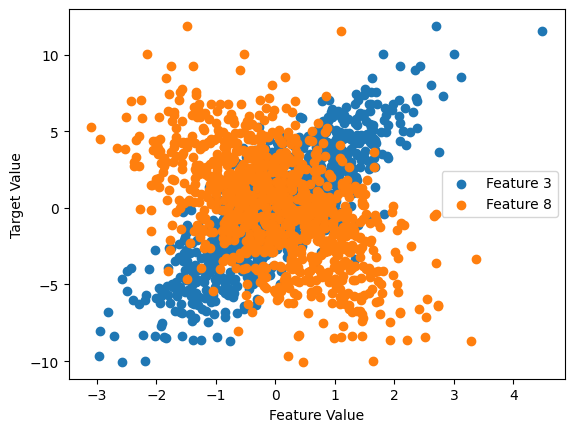

In [102]:
plt.scatter(X[:, 3], y, label='Feature 3')
plt.scatter(X[:, 8], y, label='Feature 8')
plt.xlabel('Feature Value')
plt.ylabel('Target Value')
plt.legend()
plt.show()

In [103]:
X_train_syn2, X_test_syn2, Y_train_syn2, Y_test_syn2 = train_test_split(X, y, test_size=0.2, random_state=0)

In [104]:
#normalize the data
scaler = MinMaxScaler()
X_train_syn2 = scaler.fit_transform(X_train_syn2)
X_test_syn2 = scaler.transform(X_test_syn2)

In [105]:
#Lasso parameters
iterations = 200000
step_size = 0.01
l1_penalty = 1
tolerance = 1e-4
agents = 3


In [106]:
# Lasso Regression using Gradient Descent
start_time = time.time()
print("GD")
lasso = LassoReg(step_size, iterations, l1_penalty, tolerance)
lasso.fit(X_train_syn2, Y_train_syn2, "gd")
print(lasso.iterations)
Y_predicted = lasso.predict(X_test_syn2)
print(np.corrcoef(Y_test_syn2, Y_predicted)[0, 1] ** 2)  # R2
end_time = time.time()
print("Time Gradient Descent:", end_time - start_time)

GD
5620
0.9780525513407808
Time Gradient Descent: 1.8736069202423096


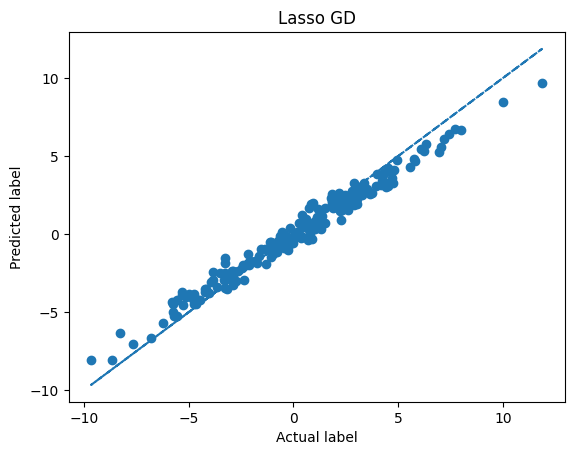

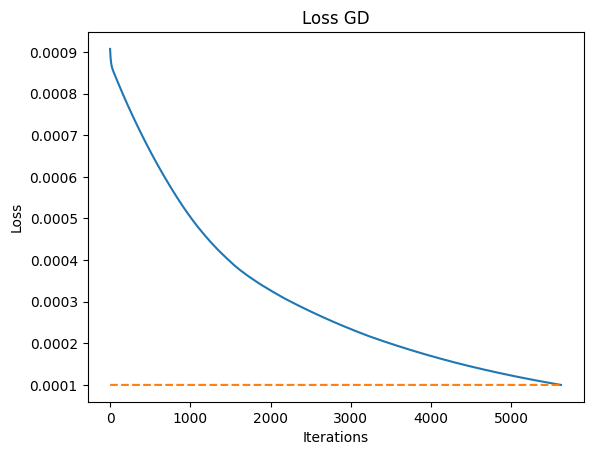

In [107]:
plot_predict("Lasso GD", Y_test_syn2, Y_predicted)
plot_loss(lasso, "Loss GD")

In [109]:
# Lasso Regression using ADMM
start_time = time.time()
print("ADMM")
lasso_admm = LassoReg(step_size, iterations, l1_penalty, tolerance)
lasso_admm.fit(X_train_syn2, Y_train_syn2, "admm")
print(lasso_admm.iterations)
Y_predicted_admm = lasso_admm.predict(X_test_syn2)
print(np.corrcoef(Y_test_syn2, Y_predicted_admm)[0, 1] ** 2)  # R2
end_time = time.time()
print("Time ADMM:", end_time - start_time)

ADMM
423
0.9791111474726806
Time ADMM: 0.2015392780303955
